In [1]:
import torch
import torchvision
from torchvision import transforms as T
from torch.utils.data import Dataset, DataLoader, random_split
from torch import nn
import torch.nn.functional as F
import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
from torchvision.datasets import ImageFolder

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from math import floor, ceil
from sklearn.model_selection import train_test_split

import shutil
import requests
import functools
import pathlib
from pathlib import Path
import shutil
from tqdm.notebook import tqdm
import os
from collections import defaultdict

from IPython.display import clear_output


matplotlib.rcParams['figure.figsize'] = (20, 5)

In [4]:
DATA_ROOT = Path('/mnt/ssd1/datasets/alexkkir/birds')
images_path = DATA_ROOT / '00_test_img_input' / 'train' / 'images'
labels_path = DATA_ROOT / '00_test_img_input' / 'train' / 'gt.csv'

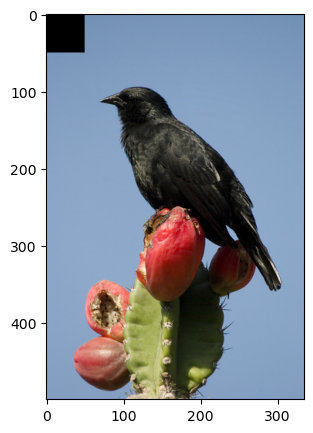

In [5]:
img = plt.imread(DATA_ROOT / 'data' / '10' / '0504.jpg').copy()
img[:50, :50, :] = 0
plt.imshow(img)

In [67]:
def test(t):
    modif = img if t is None else t(image=img)['image']
    plt.imshow(modif)
    title = 'None' if t is None else t.__class__.__name__
    plt.title(title)
    plt.show()

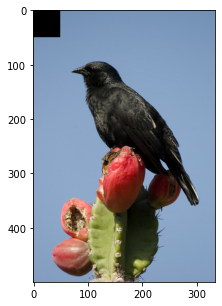

In [69]:
plt.imshow(A.HueSaturationValue()(image=img)['image'])

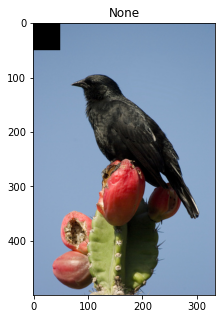

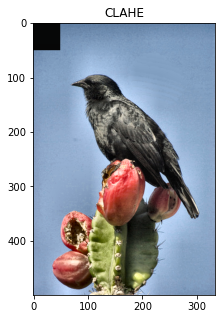

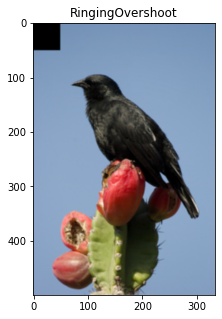

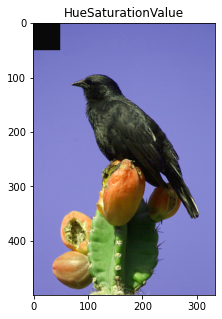

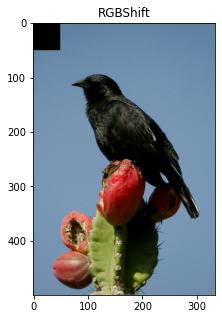

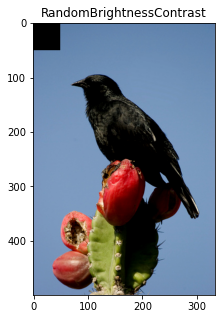

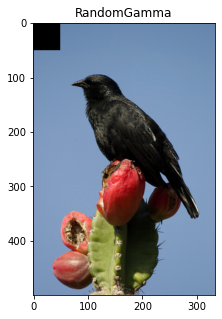

In [70]:
transforms = [
    None,
    A.CLAHE(),
    A.RingingOvershoot( blur_limit=(3, 7)),
    A.HueSaturationValue(),
    A.RGBShift(),
    A.RandomBrightnessContrast(),
    A.RandomGamma(),
]
for t in transforms:
    test(t)

In [20]:
MEAN = np.array([0.485, 0.456, 0.406])
STD = np.array([0.229, 0.224, 0.225])

test_augmentations = [
    A.Compose([
        A.Resize(224, 224),
        A.Normalize(MEAN, STD),
        ToTensorV2(),
    ]),
    A.Compose([
        A.Resize(224, 224),
        A.Rotate((5, 5)),
        A.Normalize(MEAN, STD),
        ToTensorV2(),
    ]),
    A.Compose([
        A.Resize(224, 224),
        A.Rotate((-5, -5)),
        A.Normalize(MEAN, STD),
        ToTensorV2(),
    ])
]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


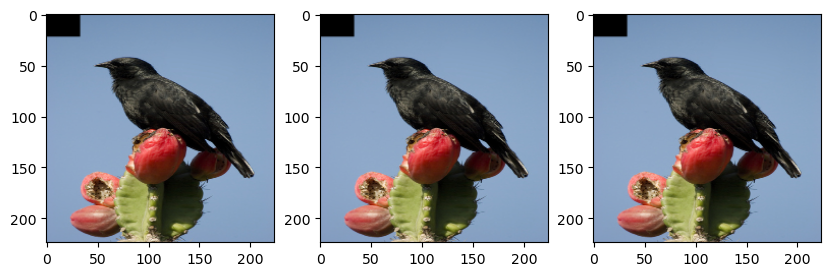

In [21]:
plt.rcParams['figure.figsize'] = (10, 3)
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.imshow(test_augmentations[i](image=img)['image'].permute(1, 2, 0) * STD + MEAN)

In [22]:
MEAN = np.array([0.485, 0.456, 0.406])
STD = np.array([0.229, 0.224, 0.225])

test_augmentations = [
    A.Compose([
        A.Resize(224, 224),
        A.Normalize(MEAN, STD),
        ToTensorV2(),
    ]),
    A.Compose([
        A.Resize(224, 224),
        A.Rotate((5, 5)),
        A.Normalize(MEAN, STD),
        ToTensorV2(),
    ]),
    A.Compose([
        A.Resize(224, 224),
        A.Rotate((-5, -5)),
        A.Normalize(MEAN, STD),
        ToTensorV2(),
    ])
]

In [23]:
class MyImageFolder(ImageFolder):
    def __getitem__(self, index):
        path_x, y = self.samples[index]
        x = self.loader(path_x)
        # x = self.images[index]
        if self.transform is not None:
            x = np.array(x)
            x = self.transform(image=x)['image']

        if self.target_transform is not None:
            y = self.target_transform(y)

        return x, y, path_x.split('/')[-1]

In [25]:
datasets = [MyImageFolder(DATA_ROOT / 'data', transform=test_augmentations[i]) for i in range(3)]
targets = datasets[0].targets

train_idx, valid_idx= train_test_split(
    np.arange(len(targets)),
    test_size=0.2,
    random_state=0,
    shuffle=True,
    stratify=targets
)

train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
valid_sampler = torch.utils.data.SubsetRandomSampler(valid_idx)

batch_size = 16
test_loaders = [DataLoader(datasets[i], batch_size=batch_size, sampler=train_sampler, num_workers=16) for i in range(3)]

In [27]:
class Model(pl.LightningModule):
    def __init__(self):
        super().__init__()

        features = torchvision.models.efficientnet_v2_s(weights=torchvision.models.EfficientNet_V2_S_Weights.IMAGENET1K_V1)
        features = list(features.children())[:-2]
        features = nn.Sequential(*features)

        self.features = features
        
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Dropout(0.8),
            nn.Linear(1280 , 500)
        )

        self.loss = nn.CrossEntropyLoss(label_smoothing=0.1)
        self.acc = lambda pred, y: torch.sum(F.softmax(pred, dim=1).argmax(dim=1) == y) / y.shape[0]

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

    def training_step(self, batch, batch_idx):
        """the full training loop"""
        x, y = batch[0], batch[1]

        pred = self(x)
        loss = self.loss(pred, y)
        
        acc = self.acc(pred, y)

        return {'loss': loss, 'acc': acc}

    def configure_optimizers(self):
        """ Define optimizers and LR schedulers. """
        optimizer = torch.optim.Adam([
            {'params': self.features.parameters(), 'lr': 3e-5 / 2},
            {'params': self.classifier.parameters()}
        ], lr=3e-4, weight_decay=3e-4)

        lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, 
            mode='max', 
            factor=0.2, 
            patience=5, 
            verbose=True)
            
        lr_dict = {
            # REQUIRED: The scheduler instance
            "scheduler": lr_scheduler,
            # The unit of the scheduler's step size, could also be 'step'.
            # 'epoch' updates the scheduler on epoch end whereas 'step'
            # updates it after a optimizer update.
            "interval": "epoch",
            # How many epochs/steps should pass between calls to
            # `scheduler.step()`. 1 corresponds to updating the learning
            # rate after every epoch/step.
            "frequency": 1,
            # Metric to monitor for schedulers like `ReduceLROnPlateau`
            "monitor": "val_acc"
        } 

        return [optimizer], [lr_dict]

    # OPTIONAL
    def validation_step(self, batch, batch_idx):
        """the full validation loop"""
        x, y = batch[0], batch[1]
        pred = self(x)
        loss = self.loss(pred, y)
        acc = self.acc(pred, y)

        return {'val_loss': loss, 'val_acc': acc}

    # OPTIONAL
    def training_epoch_end(self, outputs):
        """log and display average train loss and accuracy across epoch"""
        avg_loss = torch.stack([x['loss'] for x in outputs]).mean()
        avg_acc = torch.stack([x['acc'] for x in outputs]).mean()

        print(f"| Train_acc: {avg_acc:.2f}, Train_loss: {avg_loss:.2f}" )

        self.log('train_loss', avg_loss, prog_bar=True, on_epoch=True, on_step=False)
        self.log('train_acc', avg_acc, prog_bar=True, on_epoch=True, on_step=False)

    # OPTIONAL
    def validation_epoch_end(self, outputs):
        """log and display average val loss and accuracy"""
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        avg_acc = torch.stack([x['val_acc'] for x in outputs]).mean()

        print(f"[Epoch {self.trainer.current_epoch:3}] Val_acc: {avg_acc:.2f}, Val_loss: {avg_loss:.2f}", end= " ")

        self.log('val_loss', avg_loss, prog_bar=True, on_epoch=True, on_step=False)
        self.log('val_acc', avg_acc, prog_bar=True, on_epoch=True, on_step=False)

In [ ]:
model2 = Model()
model2.load_state_dict(torch.load('/home/alexkkir/cv-hw3-birds/runs/pl_classifier/epoch=54-val_acc=0.889.ckpt')['state_dict'])

In [26]:
def make_prediction(model, loaders, repeats=3,):
    device = torch.device('cuda:0')
    model = model.to(device)
    correct = defaultdict()
    predicted = defaultdict(list)

    for loader in loaders:
        for batch in loader:
            images, labels, names = batch
            for name, label in zip(names, labels):
                correct[name] = label

            images = images.to(device)
            pred = model.forward(images).detach().cpu()
            pred = F.softmax(pred, dim=1).argmax(dim=1)

            for name, p in zip(names, pred):
                predicted[name].append(p)

    predicted_most_common = {}
    for name, preds in predicted.items():
        most_common = max(set(preds), key=preds.count)
        predicted_most_common[name] = most_common

    n = 0
    for k in correct:
        true = correct[k]
        pred = predicted_most_common[k]
        n += true == pred
    n = float(n) / len(correct)

    acc_mean = n

    acc_single = []
    for i in range(repeats):
        n = 0
        for k in correct:
            true = correct[k]
            pred = predicted[k][i]
            n += true == pred
        n = float(n) / len(correct)

        acc_single.append(n)
    return acc_mean, acc_single